In [16]:
from KGS import *
import scipp as sc
from matplotlib.colors import LogNorm


from mpl_toolkits.axes_grid1 import make_axes_locatable

def E_to_lambda(E): 
    """
    Converts ndarray of E in [meV] to wavelength in [AA]
    """
    return 1/(0.11056*np.sqrt(E))

def lambda_to_E(lam):
    return (1/(lam*0.11056))**2

# Tuninig the ESS pulse Data treatment

## Different L0 settings on the chopper

## Treating the $\lambda$,ToF monitor

In [17]:
chop1ms_L02p3 = np.loadtxt('../BIFROST_Tuning_Sim/Chop1ms_L02p3/ToF_Lambda_Before_sampel.dat')

print(np.shape(chop1ms_L02p3)) # 0 250000 0 6

I_chop1ms = chop1ms_L02p3[0:1000]
err_chop1ms = chop1ms_L02p3[1000:2000]

#plt.imshow(np.flipud(chop1ms_L02p3[300:800, 800:1800]))

(3000, 2500)


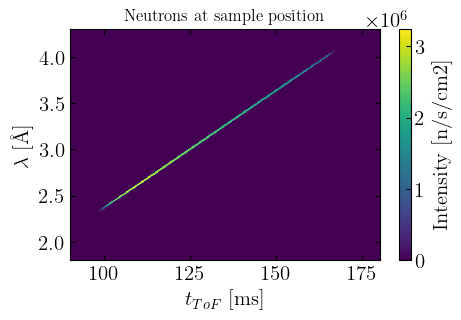

In [18]:
data = I_chop1ms

x_centers = np.linspace(0, 250, 2500)
y_centers = np.linspace(0, 6, 1000)

# ------------------------------------------------------------
# Convert centers → edges
# ------------------------------------------------------------
dx = x_centers[1] - x_centers[0]
dy = y_centers[1] - y_centers[0]

x_edges = np.concatenate([
    [x_centers[0] - dx/2],
    x_centers[:-1] + dx/2
])

y_edges = np.concatenate([
    [y_centers[0] - dy/2],
    y_centers[:-1] + dy/2
])

# ------------------------------------------------------------
# Plot using pcolormesh
# ------------------------------------------------------------

plt.figure(figsize=(5, 3))

# pcolormesh expects edges of shape (N+1, M+1)
mesh = plt.pcolormesh(x_edges, y_edges, data, shading="auto")

plt.xlabel(r'$t_{ToF}$ [ms]')
plt.ylabel(r'$\lambda$ [Å]')
plt.title("Neutrons at sample position", fontsize=12)
plt.colorbar(mesh, label="Intensity [n/s/cm2]")
plt.xlim(90,180)
plt.ylim(1.8,4.3)

plt.show()

In [19]:
# weights = 1 / error^2

print(np.shape(I_chop1ms[0]))
print(np.shape(x_centers))


(2500,)
(2500,)


In [20]:
widths = []

for i in range(I_chop1ms.shape[0]):
    row = I_chop1ms[i]

    # determine weights: support both 1-D row or 2-D row with weights in column 1
    if getattr(row, "ndim", 1) > 1 and row.shape[1] > 1:
        weights = row[:, 1]
    else:
        weights = row.ravel()

    # ensure x_centers length matches weights length
    if x_centers.shape[0] != weights.shape[0]:
        raise ValueError(
            f"Length mismatch at row {i}: len(x_centers)={x_centers.shape[0]} "
            f"!= len(weights)={weights.shape[0]}"
        )

    # if the entire row sums to zero -> append 0
    if weights.sum() == 0:
        widths.append(0.0)
        continue

    # otherwise use only positive weights for the average
    mask = weights > 0
    x = x_centers[mask]
    w = weights[mask]

    # safety: check masked arrays are non-empty and weights sum non-zero
    if x.size == 0 or w.sum() == 0:
        widths.append(0.0)
        continue

    mu = np.average(x, weights=w)
    sigma = np.sqrt(np.average((x - mu) ** 2, weights=w))

    widths.append(sigma)

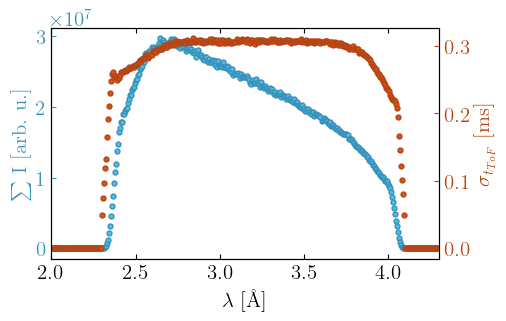

In [21]:
mpl.rcParams['lines.markersize'] = 7


fig, ax1 = plt.subplots(figsize=(5, 3))

# --- First plot (left axis) --- now using the *orange* colors ---
ax1.plot(y_centers, np.sum(I_chop1ms, axis=1), '.', color='#4dbeee', mew=1, markeredgecolor='#3992b8')
ax1.set_ylabel("$\sum$ I [arb. u.]", color='#3992b8')
ax1.tick_params(axis='y', colors='#3992b8')
ax1.set_xlabel(r'$\lambda$ [Å]')

# Create second axis sharing the same x-axis
ax2 = ax1.twinx()

# --- Second plot (right axis) --- now using the *blue* colors ---

ax2.plot(y_centers, widths, '.', color='#d95319', mew=1, markeredgecolor='#b54514')
ax2.set_ylabel(r'$\sigma_{t_{ToF}}$ [ms]', color='#b54514')
ax2.tick_params(axis='y', colors='#b54514')
ax1.set_xlim(2,4.3)
plt.show()

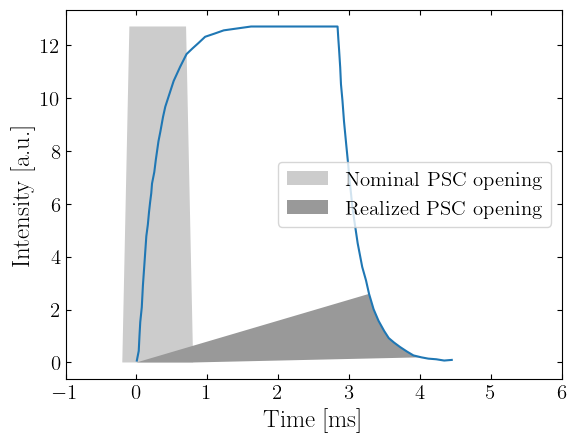

In [65]:

from scipy.io import loadmat

mat = loadmat("PulseData.mat")

PulseD = mat["PulseD"]

type(PulseD)        # numpy.ndarray
PulseD.shape      

ms_col = PulseD[:, 0]   
I_col = PulseD[:, 1] 

from matplotlib.patches import Polygon

# --- Nominal PSC opening (light grey patch) ---
x = np.array([-0.5, 0.5, 0.4, -0.4]) + 0.3
y = np.array([0, 0, 12.72, 12.72])

patch1 = Polygon(
    np.column_stack((x, y)),
    closed=True,
    facecolor=(0.8, 0.8, 0.8),
    edgecolor='none'
)
plt.gca().add_patch(patch1)

# --- Realized PSC opening (darker grey patch) ---
cut = 23
xx = np.concatenate([ms_col[:cut], [0.8, 0.0]])
yy = np.concatenate([I_col[:cut], [0.0, 0.0]])

patch2 = Polygon(
    np.column_stack((xx2, yy2)),
    closed=True,
    facecolor=(0.6, 0.6, 0.6),
    edgecolor='none'
)
plt.gca().add_patch(patch2)

# --- Moderator pulse ---
plt.plot(ms_col, I_col)

# --- Formatting to match MATLAB ---
plt.xlabel('Time [ms]', fontsize=18, fontfamily='Times New Roman')
plt.ylabel('Intensity [a.u.]', fontsize=18, fontfamily='Times New Roman')
plt.xlim(-1, 6)

# --- Legend (order matters) ---
plt.legend(
    [patch1, patch2],
    ['Nominal PSC opening', 'Realized PSC opening'],
    loc='best'
)

plt.show()



In [41]:
def dEi(Ei, dt, t):
    return 2*(dt/t)*Ei

dE_i = dEi(lambda_to_E(y_centers), widths, x_centers[750:1750])

x_E = lambda_to_E(y_centers)
print(len(x_E))
print(len(x_centers))


theoretical = dEi(x_E, np.ones(1000)*0.3, x_centers[750:1750])


1000
2500


/var/folders/f1/pbcb3xr90wn7_tx3k9d6kcyr0000gn/T/ipykernel_2015/223165792.py:15: RuntimeWarning: divide by zero encountered in divide
  return (1/(lam*0.11056))**2
/var/folders/f1/pbcb3xr90wn7_tx3k9d6kcyr0000gn/T/ipykernel_2015/1039626058.py:2: RuntimeWarning: invalid value encountered in multiply
  return 2*(dt/t)*Ei


/var/folders/f1/pbcb3xr90wn7_tx3k9d6kcyr0000gn/T/ipykernel_2015/223165792.py:15: RuntimeWarning: divide by zero encountered in divide
  return (1/(lam*0.11056))**2


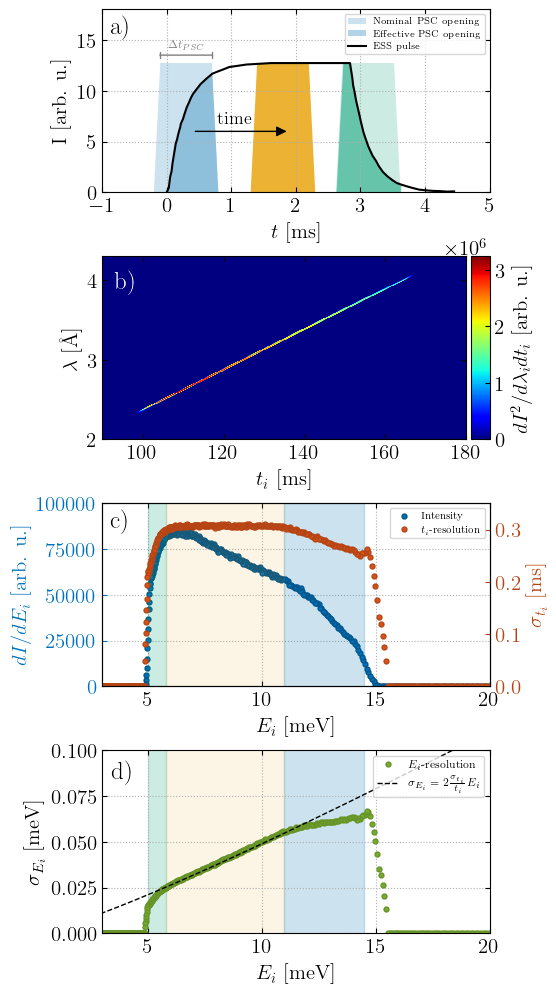

In [182]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 12))


ax_new = fig.add_subplot(4, 1, 1)

ax_new.annotate(
    '',
    xy=(-0.15, 13.5),
    xytext=(0.75, 13.5),
    arrowprops=dict(arrowstyle='|-|',mutation_scale=2, linewidth=1.0, color='grey')
)
ax_new.text(0.5 * (-0.15 + 0.75), 14, r'$\Delta t_{PSC}$', ha='center', va='bottom', fontsize=8, color='grey')

patch1 = Polygon(
    np.column_stack((x, y)),
    closed=True,
    facecolor='#0072B2',
    alpha=0.2,
    edgecolor='none'
)
ax_new.add_patch(patch1)

patch2 = Polygon(
    np.column_stack((xx, yy)),
    closed=True,
    facecolor='#0072B2',
    alpha=0.3,
    edgecolor='none'
)
ax_new.add_patch(patch2)

patch3 = Polygon(
    np.column_stack((x+1.5, y)),
    closed=True,
    facecolor='#E69F00',
    alpha=0.8,
    edgecolor='none'
)
ax_new.add_patch(patch3)


patch4 = Polygon(
    np.column_stack((x+2.82, y)),
    closed=True,
    facecolor='#009E73',
    alpha=0.2,
    edgecolor='none'
)
ax_new.add_patch(patch4)

cut_l = 33
cut_h = 56
xx2 = np.concatenate([ms_col[cut_l:cut_h], [3.63, 2.63]])
yy2 = np.concatenate([I_col[cut_l:cut_h], [0.0, 0.0]])


patch5 = Polygon(
    np.column_stack((xx2, yy2)),
    closed=True,
    facecolor='#009E73',
    alpha=0.5,
    edgecolor='none'
)
ax_new.add_patch(patch5)

pulse_line, = ax_new.plot(ms_col, I_col,color='k')  # <-- your new plot


y_arrow = 6.0
x1 = 0.4         # patch1 center
x2 = 1.9       # patch2 center

x3 = 1.9    # patch3 center
x4 = 2.6   # patch4 center
ax_new.annotate(
    '',
    xy=(x2, y_arrow),
    xytext=(x1, y_arrow),
    arrowprops=dict(arrowstyle='-|>', linewidth=1.0, color='k')
)
ax_new.text(
    1.05,
    y_arrow + 0.4,
    'time',
    ha='center',
    va='bottom',
    color='k',
    fontsize=13
)

# ax_new.annotate(
#     '',
#     xy=(x4, y_arrow),
#     xytext=(x3, y_arrow),
#     arrowprops=dict(arrowstyle='-|>', linewidth=1.0, color='k')
# )
# ax_new.text(
#     2.1,
#     y_arrow + 0.4,
#     't',
#     ha='center',
#     va='bottom',
#     fontsize=13
# )


ax_new.set_ylabel("I [arb. u.]")
ax_new.set_xlabel("$t$ [ms]")
ax_new.set_ylim(0,18)
ax_new.set_xlim(-1,5)
ax_new.text(0.02, 0.87, r'a)', transform=ax_new.transAxes,
            weight='bold', fontsize=18)
ax_new.grid(linestyle='dotted')
ax_new.legend(
    [patch1, patch2, pulse_line],
    ['Nominal PSC opening', 'Effective PSC opening',  'ESS pulse'],
    fontsize=6.5,loc="upper right"
)

# ------------------------
# --- Subplot 1 (top) ----
# ------------------------
ax_top = fig.add_subplot(4, 1, 2)

mesh = ax_top.pcolormesh(x_edges, y_edges, data, shading="auto", cmap='jet')

ax_top.set_xlabel(r'$t_i$ [ms]')
ax_top.set_ylabel(r'$\lambda$ [Å]')
#ax_top.set_title("Neutrons at sample position", fontsize=12)
ax_top.set_xlim(90, 180)
ax_top.set_ylim(2, 4.3)
ax_top.text(93, 3.9, r'b)', weight='bold', color='white', fontsize=18)


divider = make_axes_locatable(ax_top)
cax = divider.append_axes("right", size="5%", pad=0.05)  # colorbar axes
cbar = fig.colorbar(mesh, cax=cax)
cbar.set_label(r"$dI^2/d\lambda_i dt_i$ [arb. u.]")

m_n = 1.67492749804e-27 # [kg]
hbar = 6.582119569e-13 # meV*s

Intensities = np.where(np.sum(I_chop1ms, axis=1)>0, np.sum(I_chop1ms, axis=1) * (m_n*y_centers**3)/(hbar**2*(2*np.pi)**2), 0)


# ---------------------------
# --- Subplot 2 (bottom) ----
# ---------------------------
ax1 = fig.add_subplot(4, 1, 3)
# Left axis
ax1.plot(
    lambda_to_E(y_centers), Intensities, '.',
    markerfacecolor='#0072BD',  markeredgecolor='#005287', label='Intensity'
)
ax1.set_ylabel(r"$dI/dE_i$ [arb. u.]", color='#0072BD')
ax1.tick_params(axis='y', colors='#0072BD')
ax1.set_xlabel(r'$E_i$ [meV]')
ax1.set_xlim(3, 20)
ax1.set_ylim(0, 1e5)


# Right axis (twin)
ax2 = ax1.twinx()
ax2.plot(
    lambda_to_E(y_centers), widths, '.',
    color='#d95319', mew=1, markeredgecolor='#b54514', label='$t_i$-resolution'
)
ax2.set_ylabel(r'$\sigma_{t_i}$ [ms]', color='#b54514')
ax2.tick_params(axis='y', colors='#b54514')
ax1.grid(linestyle='dotted')
ax2.set_ylim(0, 0.35)
ax2.set_yticks([0,0.1,0.2,0.3])

start_idx = 375
end_idx = 425

x_start = y_centers[start_idx]
x_end   = y_centers[end_idx]

ax2.fill_betweenx(y=[-0.01, 0.35], x1=5.0, x2=5.8, color='#009E73', alpha=0.2)
ax2.fill_betweenx(y=[-0.01, 0.35], x1=5.8, x2=11, color='#E69F00', alpha=0.1)
ax2.fill_betweenx(y=[-0.01, 0.35], x1=11, x2=14.5, color='#0072B2', alpha=0.2)

# One combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1 + h2, l1 + l2, fontsize=7, loc="best")

ax2.text(0.02, 0.87, r'c)', transform=ax2.transAxes,
            weight='bold', fontsize=18)

ax3 = fig.add_subplot(4, 1, 4)

ax3.plot(lambda_to_E(y_centers), dE_i, '.', markerfacecolor='#77AC30', markeredgecolor='#669428', label='$E_i$-resolution')
ax3.set_xlabel(r'$E_i$ [meV]')
ax3.set_ylabel(r'$\sigma_{E_i}$ [meV]')
ax3.set_xlim(3, 20)
ax3.set_ylim(0, 0.1)
ax3.fill_betweenx(y=[-0.01, 0.35], x1=5.0, x2=5.8, color='#009E73', alpha=0.2)
ax3.fill_betweenx(y=[-0.01, 0.35], x1=5.8, x2=11, color='#E69F00', alpha=0.1)
ax3.fill_betweenx(y=[-0.01, 0.35], x1=11, x2=14.5, color='#0072B2', alpha=0.2)
ax3.plot(lambda_to_E(y_centers), theoretical, '--', color='black', lw=1, label=r'$\sigma_{E_i} = 2 \frac{\sigma_{t_i}}{t_i}E_i$')
ax3.legend(fontsize=8,loc="upper right")

ax3.grid(linestyle='dotted')
ax3.text(3.4, 0.085, r'd)', weight='bold', color='black', fontsize=18)

plt.subplots_adjust(hspace=0.35)
plt.savefig('../../Figures/PNG/PSC_tuning.png', format='png',dpi=200, bbox_inches='tight')


In [ ]:
int_I = np.sum(I_chop1ms, axis=1)

setting = np.sum(int_I[start_idx:end_idx])


print('Available wavelength interval =', x_start, 'Å to', x_end, 'Å')

print('Available Ei interval =', lambda_to_E(x_start), 'meV to', lambda_to_E(x_end), 'meV')

print('Integrated intensity in full pulse', np.sum(int_I))

print('Integrated intensity in edge setting = ', setting)

print('Fraction used intensity', setting/np.sum(int_I))

print(r'Max $\sigma_i$ =', max(widths[start_idx:end_idx]))


# In order to determine the effct of this on the energy resolution I need to be able to take the current width of time at the sample position and calculate back to what the artificially good PSC opening was.
# This will give me my new sigma_ToF which I can use to determine the energy resolution. 




In [ ]:


plt.figure()
plt.plot(lambda_to_E(y_centers), dE_i)
plt.xlabel(r'$E_i$ [meV]')
plt.ylabel(r'$\sigma_{E_i}$ [meV]')
plt.xlim(3, 20)

In [ ]:

widths = []

for i in range(I_chop1ms.shape[1]):
    weights = I_chop1ms[:,i]

    # ensure x_centers length matches weights length
    if y_centers.shape[0] != weights.shape[0]:
        raise ValueError(
            f"Length mismatch at row {i}: len(x_centers)={y_centers.shape[0]} "
            f"!= len(weights)={weights.shape[0]}"
        )

    # if the entire row sums to zero -> append 0
    if weights.sum() == 0:
        widths.append(0.0)
        continue

    # otherwise use only positive weights for the average
    mask = weights > 0
    x = y_centers[mask]
    w = weights[mask]

    # safety: check masked arrays are non-empty and weights sum non-zero
    if x.size == 0 or w.sum() == 0:
        widths.append(0.0)
        continue

    mu = np.average(x, weights=w)
    sigma = np.sqrt(np.average((x - mu) ** 2, weights=w))

    widths.append(sigma)

print(np.shape(widths))
print(np.shape(x_centers))


In [ ]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# --- First plot (left axis) --- now using the *orange* colors ---
ax1.plot(x_centers, np.sum(I_chop1ms, axis=0), '.', color='#4dbeee', mew=1, markeredgecolor='#3992b8')
ax1.set_ylabel("$\sum$ I [arb. u.]", color='#3992b8')
ax1.tick_params(axis='y', colors='#3992b8')
ax1.set_xlabel(r'$t_i$ [ms]')

# Create second axis sharing the same x-axis
ax2 = ax1.twinx()

# --- Second plot (right axis) --- now using the *blue* colors ---

ax2.plot(x_centers, widths, '.', color='#d95319', mew=1, markeredgecolor='#b54514')
ax2.set_ylabel(r'$\sigma_{\lambda}$ [Å]', color='#b54514')
ax2.tick_params(axis='y', colors='#b54514')

plt.show()

In [ ]:
print(x_centers[1]-x_centers[0])